# Apply Topic Modelling Analysis on COVID-19 Documents with NMF

This jupyter notebook demonstrates document clustering with NMF topic modelling and generating tags from the clustered documents.

**About NMF**

- NMF : Non-Negative Matrix Factorization (NMF) is an unsupervised technique. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative. Using the original matrix (X), NMF will give you two matrices (W and H). W is the topics it found and H is the coefficients (weights) for those topics. In other words, X is articles by words (original), H is articles by topics and W is topics by words.


In [19]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import re
import pickle
import json
import nltk
import ast
import datetime as dt
import seaborn as sns
import operator
import re
import pathlib
import timeit
from wordcloud import WordCloud
from collections import Counter
from sklearn import decomposition
from sklearn.decomposition import NMF
from gensim.models import Word2Vec
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

In [3]:
DATA_PATH = '../data/preprocessed_data/'
OUTPUT_PATH = '../data/figures/'
No_TOP_KEYOWRDS = 5

## Load data

In [4]:
df = pd.read_csv(DATA_PATH + "preprocessed_data.tsv", sep='\t', encoding='utf-8')
V = pickle.load( open(DATA_PATH + "_V_tfidf.pkl", "rb") )
D = pickle.load( open(DATA_PATH + "_D_tfidf.pkl", "rb") )
w2v_model = Word2Vec.load('../data/covid_word2vec/covid_100d.model')

In [5]:
df.shape

(557956, 2)

## Find the optimal topic size by coherence means 

In [6]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if w2v_model.wv.__contains__(pair[0]) and w2v_model.wv.__contains__(pair[1]):
                similarity = w2v_model.wv.similarity(pair[0], pair[1])
                pair_scores.append(max(0, similarity)) # return positive value
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


In [7]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [8]:
def get_coherence(V, D, w2v_model, No_TOP_KEYOWRDS):

    kmin, kmax = 3, 30
    
    topic_models = []
    k_values = []
    coherences = []
    # try each value of k
    for k in range(kmin,kmax+1):
        # run NMF
        model = decomposition.NMF( init="nndsvd", n_components=k, random_state=1, max_iter=800) # 'nndsvd' works best for sparse data where the most of value are 0
        W = model.fit_transform( D ) # fit vectorization results
        H = model.components_    
        # store for later
        topic_models.append( (k,W,H) )
        # Get top-n topic descriptors 
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( V.get_feature_names(), H, topic_index, No_TOP_KEYOWRDS ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( calculate_coherence( w2v_model, term_rankings ) )
   
    return k_values, coherences

In [ ]:
No_TOP_KEYOWRDS = 5
k_values, coherences = get_coherence(V, D, w2v_model, No_TOP_KEYOWRDS)

In [37]:
coherence_df = pd.DataFrame()
coherence_df['k'] = k_values
coherence_df['coherences mean'] = coherences
coherence_df.to_csv(OUTPUT_PATH + "coherence_mean.csv", index=False)

In [38]:
def show_coherence(k_values, coherences, No_TOP_KEYOWRDS):
    fig = plt.figure(figsize=(12,8))
    # create the line plot
    ax = plt.plot( k_values, coherences )
    #plt.title('Coherence Mean with {} top keywords'.format(No_TOP_KEYOWRDS))
    plt.title('Coherence Mean')
    plt.xticks(k_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    plt.grid()
    # add the points
    plt.scatter( k_values, coherences, s=36)
    plt.savefig('../img/coherence.jpeg', doi=400, bbox_inches='tight') 
    # show the plot
    plt.show()

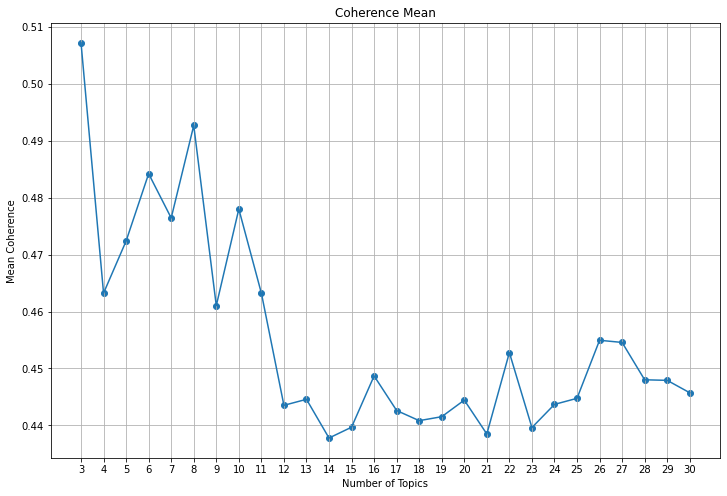

In [39]:
show_coherence(k_values, coherences, No_TOP_KEYOWRDS) 

## Apply topic modelling

In [10]:
k = 8
NMF_model = NMF(n_components=k, init='nndsvd', random_state=1).fit(D)
H = NMF_model.transform(D) # articles by topic
W = NMF_model.components_  # topics by words.

In [11]:
# identify first and second topic for each article

top2_clusters_df = pd.DataFrame()
top2_clusters_df['_id'] = df['_id']

top_1_cluster_list=[]
top_2_cluster_list=[]
top_1_cluster_weight_list=[]
top_2_cluster_weight_list=[]

for a in H:
    top_2_idx = np.argsort(a)[-2:]
    top_2_values = [a[i] for i in top_2_idx]
    top_1_cluster_list.append(str(top_2_idx[1]))
    top_2_cluster_list.append(str(top_2_idx[0]))
    top_1_cluster_weight_list.append(round(top_2_values[1], 5))
    top_2_cluster_weight_list.append(round(top_2_values[0], 5))
    
top2_clusters_df['top1_cluster'] = top_1_cluster_list
top2_clusters_df['top2_cluster'] = top_2_cluster_list
top2_clusters_df['top1_cluster_weight'] = top_1_cluster_weight_list
top2_clusters_df['top2_cluster_weight'] = top_2_cluster_weight_list

# Explore topic modelling results

## Print clusters keywords 

In [13]:
def print_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    feature_names = V.get_feature_names()
    fig, axes = plt.subplots(2, 4, figsize=(30, 16), sharex=True)
    axes = axes.flatten()
   
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
    
        for p in ax.patches:
            if topic_idx == 0:
                ax.annotate(str(round(p.get_width(),2)), (6.5, p.get_y() + p.get_height()),size=16)
            else:
                ax.annotate(str(round(p.get_width(),2)), (5.5, p.get_y() + p.get_height()),size=16)
            #ax.annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height()/8),fontsize=12)
            #print(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height()))
    
        ax.set_title(f"Cluster# {topic_idx}", fontdict={"fontsize": 20})
        
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

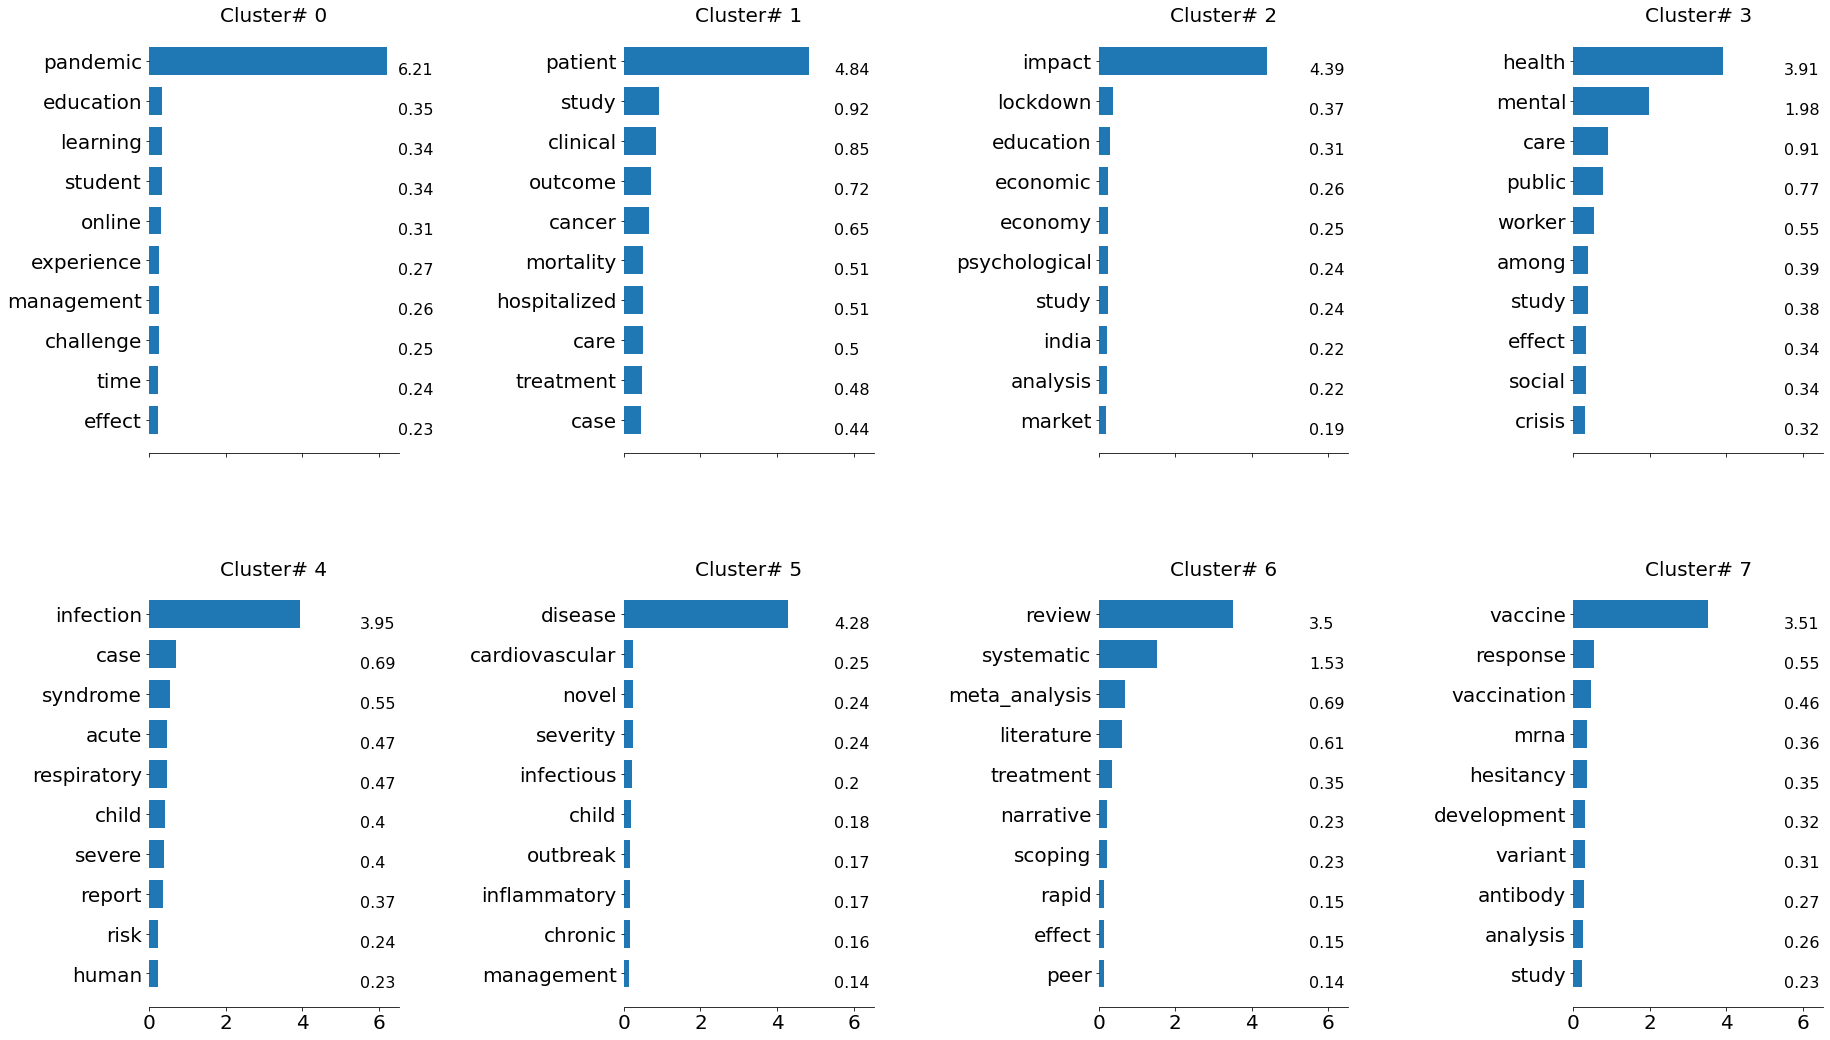

In [14]:
print_top_keyword_weights(NMF_model, k, 10, V)

## Print number of articles in the clusters

In [17]:
def show_distribution(unique, top1_num_of_articles):
    plt.figure(figsize=(12, 6))

    plt.bar(unique, top1_num_of_articles)
    plt.yticks(fontsize=14)
    plt.xticks(unique, unique)
    plt.ylabel('Number of research articles', fontweight='bold', fontsize=14)
    plt.xlabel('Clusters', fontweight='bold', fontsize=14)
    
    for index, value in enumerate(top1_num_of_articles):
        plt.text(index-0.4, top1_num_of_articles[index]+1000, f"{top1_num_of_articles[index]:,}", fontsize=12)
    plt.show()

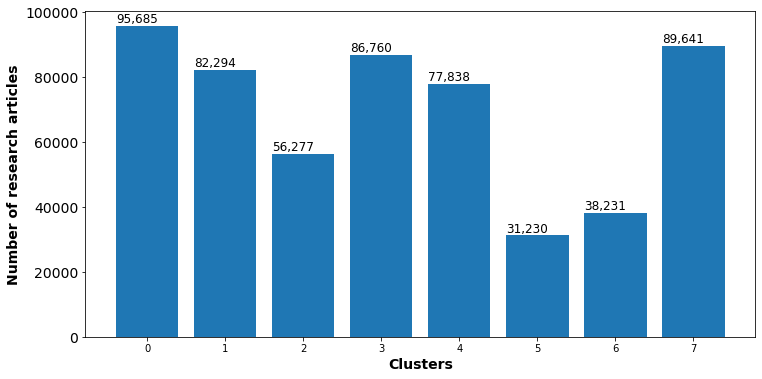

In [18]:
# show number of articles per cluster
articles_num = []
for cluster in range(k):
    articles_num.append(len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster)]))
    
unique = range(k)
show_distribution(unique, articles_num)

## Article co-occurrence 

In [20]:
# Calculate Sum of x and number of x

c_pair_x_num = {} # coumt number of x
c_pair_x_sum = {} # sum of x
for index, row in top2_clusters_df.iterrows():
    c_pair = (row['top1_cluster'], row['top2_cluster'])
    if c_pair not in c_pair_x_num.keys():
        c_pair_x_num[c_pair] = 1
    else:
        c_pair_x_num[c_pair] += 1

In [21]:
# save the results of calculation

co_oc_df = pd.DataFrame(columns=['Cluster1', 'Cluster2', '# articles'])
for i in range(k):
    for j in range(k):
        if i == j:continue
        co_oc_df = co_oc_df.append({
            "Cluster1":str(i),
            "Cluster2":str(j),
            "# articles":str(c_pair_x_num[(str(i), str(j))] + c_pair_x_num[(str(j), str(i))])}, ignore_index=True)

# convert DF to matrix format
matrix_df = pd.DataFrame()
for c1 in range(k):
    placeholders = []
    for c2 in range(k):
        placeholders.append(0)
    matrix_df[c1] = placeholders
    
for index, row in co_oc_df.iterrows():
    cluster1 = int(str(row['Cluster1']).replace('.0', ''))
    cluster2 = int(str(row['Cluster2']).replace('.0', ''))
    
    cooccurrence = row['# articles']
    num_articles_in_first_collection = len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster1)])
    num_articles_in_second_collection = len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster2)])
    co_rate = round(int(cooccurrence)/(num_articles_in_first_collection + num_articles_in_second_collection), 3)
    matrix_df[cluster2].iloc[cluster1] = co_rate

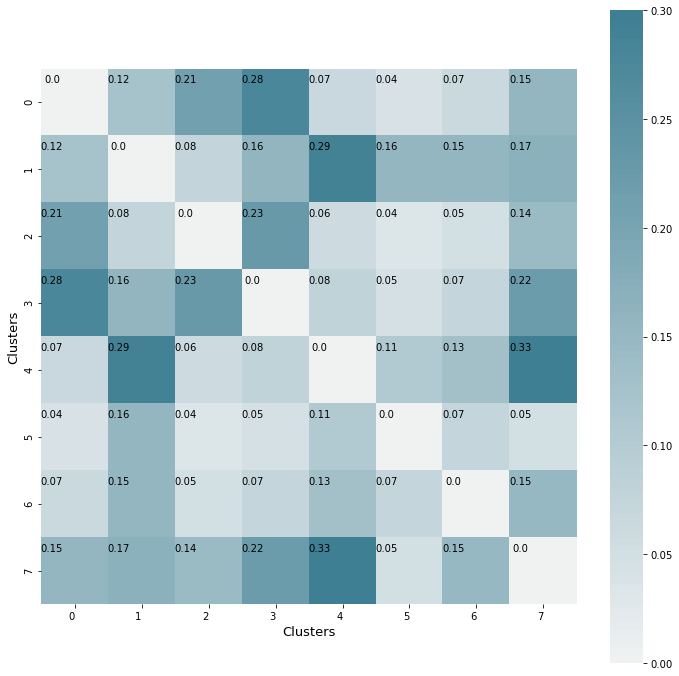

In [22]:
# draw correlation matrix

fig, ax = plt.subplots(figsize=(12,12))         
ax = sns.heatmap(
    matrix_df, 
    vmin=0, vmax=0.3, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='right'
);
j = k
for c in matrix_df.columns:
    i = 0
    for index, row in matrix_df.iterrows():
        value = row[c]
        ax.text(i/k+0.02, j/k-0.02, round(value, 2), horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes)
        i += 1
    j -= 1
plt.xlabel('Clusters', fontsize = 13) 
plt.ylabel('Clusters', fontsize = 13) 
plt.show()

## Topc weights

In [23]:
topic_w_list = []
for c in range(k):
    sub_df1 = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '{}'.format(c)]
    total_weight = 0
    for a in sub_df1:
        total_weight += a
    topic_w_list.append(round(total_weight/len(sub_df1), 4))

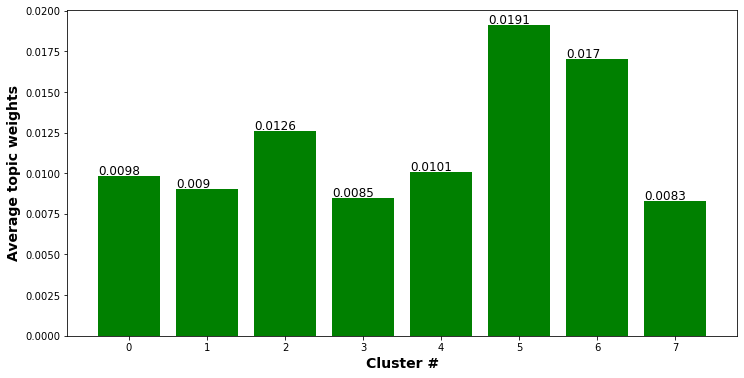

In [24]:
# draw figure
plt.figure(figsize=(12, 6))
plt.bar(unique, topic_w_list, color='green')
#plt.yticks(fontsize=14)
plt.xticks(unique, unique)
plt.ylabel('Average topic weights', fontweight='bold', fontsize=14)
plt.xlabel('Cluster #', fontweight='bold', fontsize=14)
for index, value in enumerate(topic_w_list):
    plt.text(index-0.4, topic_w_list[index]+0.0001, topic_w_list[index], fontsize=12)    
plt.show()

## Trend of articles per cluster

In [37]:
# merge the result to preprocessed data

covid_df = pd.read_csv(DATA_PATH + "english_covid_articles.tsv", sep='\t', encoding='utf-8') 
df = pd.merge(top2_clusters_df[['_id', 'top1_cluster']], covid_df, on='_id', how='left')

In [38]:
def cleaning_date_columns(date):
    try:
        row_value = ast.literal_eval(date)
        date = str(row_value['date-parts'])
        cleaned_date = date.replace('[', '')
        cleaned_date = cleaned_date.replace(']', '')
        cleaned_date = cleaned_date.replace(', ', '-')
        return cleaned_date
    except:
        return date

In [40]:
# clean the date fields
df['created'] = df['created'].apply(lambda x: cleaning_date_columns(x)) 
df['published'] = df['published'].apply(lambda x: cleaning_date_columns(x)) 
# convert the date fields
df['month'] = pd.to_datetime(df['created']).dt.to_period('M')
df['created'] = pd.to_datetime(df['created']).dt.to_period('D')
df['published'] = pd.to_datetime(df['published']).dt.to_period('D')
# sort by month
sorted_df = df.sort_values(by=['month'], inplace=False) # sort by date

In [43]:
# Only use top1 cluster

sub_df = sorted_df[['_id', 'top1_cluster', 'month']]
sub_df['top1_cluster'] = sub_df['top1_cluster'].apply(lambda x:'Cluster#' + '{:02d}'.format(int(x)))

groupby_sub_df = sub_df.groupby(['month', 'top1_cluster'])["_id"].count().reset_index(name="count")

# convert pivot table, thus each topic become column where value indicate number of document
table = pd.pivot_table(groupby_sub_df, values='count', index=['month'],
                    columns=['top1_cluster'], aggfunc=np.sum, fill_value=0)

table = table.reindex(sorted(table.columns), axis=1)

# convert table where values are cumulative
cum_table = table.cumsum(axis=0)

rank_cum_table = pd.DataFrame(columns=list(cum_table.columns))
i = 0
for index, row in cum_table.iterrows():
    l = cum_table.iloc[i]
    result = [sorted(l, reverse=True).index(x)+1 for x in l]
    rank_cum_table.loc[i] = result
    i += 1
    
rank_cum_table.index= cum_table.index

In [44]:
def bumpchart(df, selected_collections, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    fig = plt.figure(figsize=(9,5))
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    flag = 0
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)
            
        if col not in selected_collections:
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color='grey', alpha=0.1)
            
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color='green', alpha=0.1)
                
                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
        else: # highlight selected values
            if flag != 1: c = 'red'
            else: c='blue'
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color=c, label=col)
            left_yaxis.legend(loc='upper right', fontsize=12)
            left_yaxis.set_xlabel("Date")
            left_yaxis.set_ylabel("Rank")
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color=c)

                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
            flag = 1
    # Number of lines
    lines = len(df.columns)
    y_ticks = [*range(0, lines)]
    
    x_ticks = []
    for j in range(1, len(df.index)+1, 12):
        x_ticks.append(rank_cum_table.index[j])
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    axis.xaxis.set_major_locator(plt.MaxNLocator(12))
    
    return axes

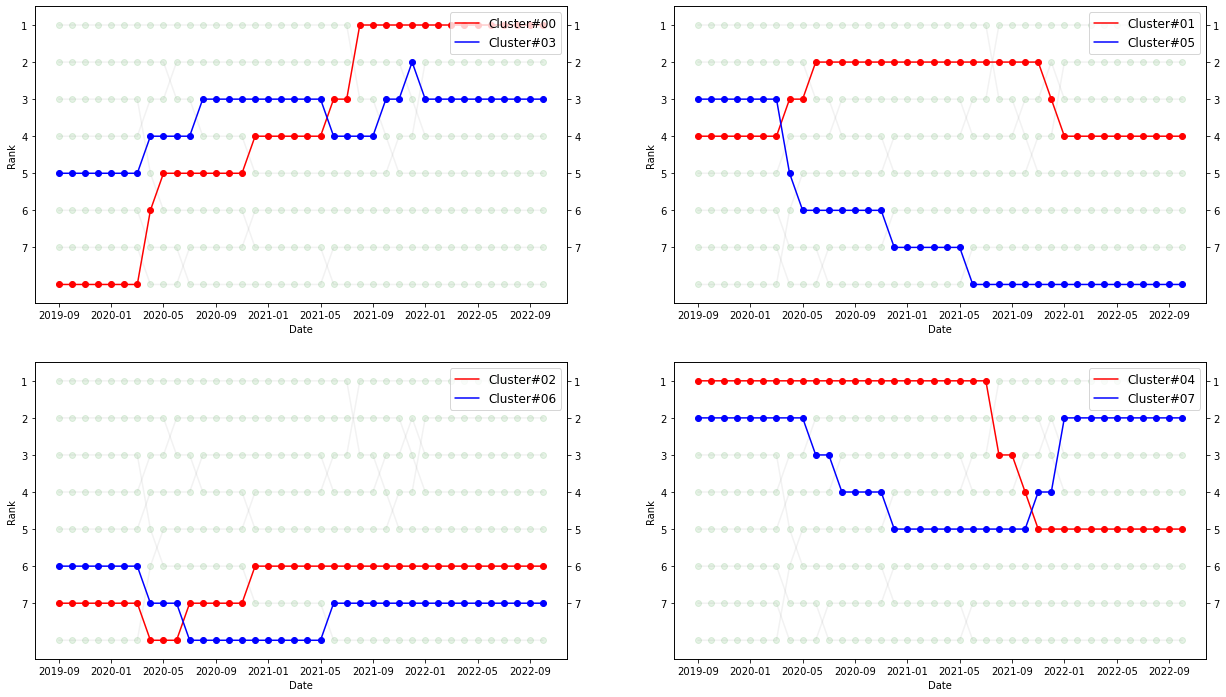

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

In [46]:
fig, axs = plt.subplots(2,2, figsize=(21,12))

last_month = 38
rank_cum_table.index = rank_cum_table.index.astype(str)

bumpchart(rank_cum_table.tail(last_month), ['Cluster#00', 'Cluster#03'], show_rank_axis= False, scatter=True, ax=axs[0][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#01', 'Cluster#05'], show_rank_axis= False, scatter=True, ax=axs[0][1])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#02', 'Cluster#06'], show_rank_axis= False, scatter=True, ax=axs[1][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#04', 'Cluster#07'], show_rank_axis= False, scatter=True, ax=axs[1][1])

## Wordcloud

We create wordcloud for each cluster based on word frequency of top 1 cluster articles (Exclude articles matched with top2 clusters). 

In [84]:
import random 

def getRandomCol():
    r = random.randrange(30, 180)
    g = random.randrange(30, 180)
    b = random.randrange(30, 180)
    return (r, g, b)

def show_wordcloud(df):
    #topics = list(set(df['research_topic']))
    i = 0
    fig = plt.figure(figsize=(18,5))
    for t in range(k):
        ax = fig.add_subplot(2,4,i+1)
        topic_df = df.loc[df['top1_cluster'] == str(t)]
        text = ''
        for index, row in topic_df.iterrows():
            text += row['text']
        wordcloud = WordCloud(background_color="white", collocations=False).generate(str(text))
        plt.title("Cluster {}".format(t))
        colour = getRandomCol()
        ax.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: colour))
        ax.axis('off')
        i += 1
    plt.tight_layout()
    plt.show()

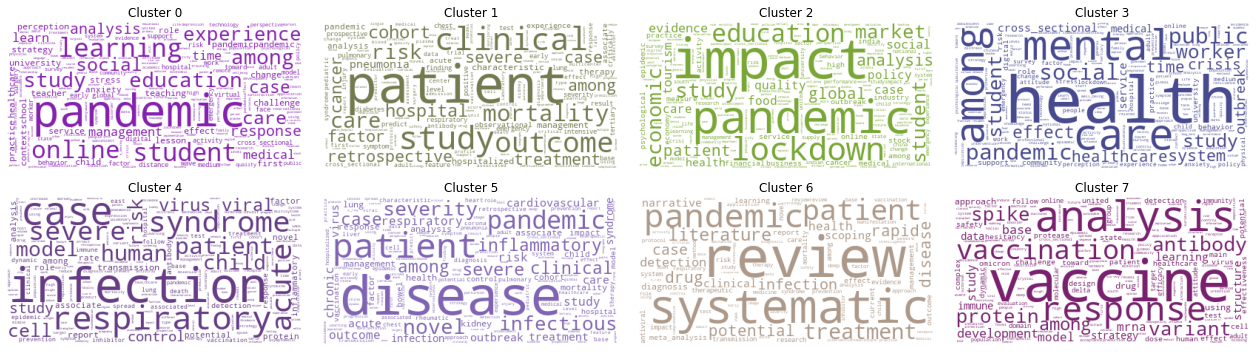

In [85]:
show_wordcloud(df)

## MetaData

In [48]:
def count_publisher(df):
    missing_article = df['publisher'].isnull().sum()
    percent = round(missing_article/len(df)*100, 1)
    publisher_df = df.groupby('publisher')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    publisher_df.columns = ['publisher','Number of publications']
    return publisher_df

In [49]:
def count_subjects(df):
    missing_article = df['subject'].isnull().sum()
    subjects_dict = {}
    for index, row in df.iterrows():
        if len(str(row['subject'])) > 3:
            subjects = eval(row['subject'])
            for s in subjects:
                if s in subjects_dict.keys():
                    subjects_dict[s] += 1
                else:
                    subjects_dict[s] = 1

    sorted_sub_dict = dict( sorted(subjects_dict.items(), key=operator.itemgetter(1),reverse=True))
    subject_df = pd.DataFrame()
    subject_df['Subjects'] = sorted_sub_dict.keys()
    subject_df['Number of publications'] = sorted_sub_dict.values()
    return subject_df

In [50]:
def count_container(df):
    df['container-title'] = df['container-title'].astype(str)
    missing_article = len(df.loc[df['container-title'] == 'nan'])
    df = df.loc[df['container-title'] != 'nan']
    container_df = df.groupby('container-title')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    container_df.columns = ['container_title','Number of publications']
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("['", ''))
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("']", ''))
    return container_df

In [51]:
def count_funder(df):
    df['funder'] = df['funder'].astype(str)
    missing_article = len(df.loc[df['funder'] == 'nan'])
    df = df.loc[df['funder'] != 'nan']
    funder_dict = {}
    for index, row in df.iterrows():
        if len(str(row['funder'])) > 3:
            funders = eval(row['funder'])
            for f in funders:
                try:
                    funder = f['name']
                    if funder in funder_dict.keys():
                        funder_dict[funder] += 1
                    else:
                        funder_dict[funder] = 1
                except:
                    continue

    sorted_funder_dict = dict( sorted(funder_dict.items(), key=operator.itemgetter(1),reverse=True))
    funder_df = pd.DataFrame()
    funder_df['Funders'] = sorted_funder_dict.keys()
    funder_df['Number of publications'] = sorted_funder_dict.values()
    return funder_df

In [52]:
def draw_subplots(top_n, df1, df2, df3, df4):
    fig, axs = plt.subplots(4,1,figsize=(12,13))
    
    x = list(df1['publisher'].iloc[:top_n])
    y = list(df1['Number of publications'].iloc[:top_n])     
    axs[0].barh(x, y, color='#728FCE')
    # top shows biggest value
    axs[0].invert_yaxis() 
    # for showing values on bar
    for p in axs[0].patches:
        axs[0].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[0].title.set_text("Top publishers")
    
    
    x = list(df2['Subjects'].iloc[:top_n])
    y = list(df2['Number of publications'].iloc[:top_n])     
    axs[1].barh(x, y, color='#7BCCB5')
    # top shows biggest value
    axs[1].invert_yaxis() 
    # for showing values on bar
    for p in axs[1].patches:
        axs[1].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[1].title.set_text("Top subjects")
    
    x = list(df3['container_title'].iloc[:top_n])
    y = list(df3['Number of publications'].iloc[:top_n])     
    axs[2].barh(x, y, color='#FFE87C')
    # top shows biggest value
    axs[2].invert_yaxis() 
    # for showing values on bar
    for p in axs[2].patches:
        axs[2].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[2].title.set_text("Top journals/conferences")
    
    x = list(df4['Funders'].iloc[:top_n])
    y = list(df4['Number of publications'].iloc[:top_n])     
    axs[3].barh(x, y)
    # top shows biggest value
    axs[3].invert_yaxis() 
    # for showing values on bar
    for p in axs[3].patches:
        axs[3].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[3].title.set_text("Top funders")
    
    #plt.savefig('../img/top-{}-articles-metadata.jpeg'.format(top_n), doi='400', bbox_inches='tight')     
    

Number of articles: 557956


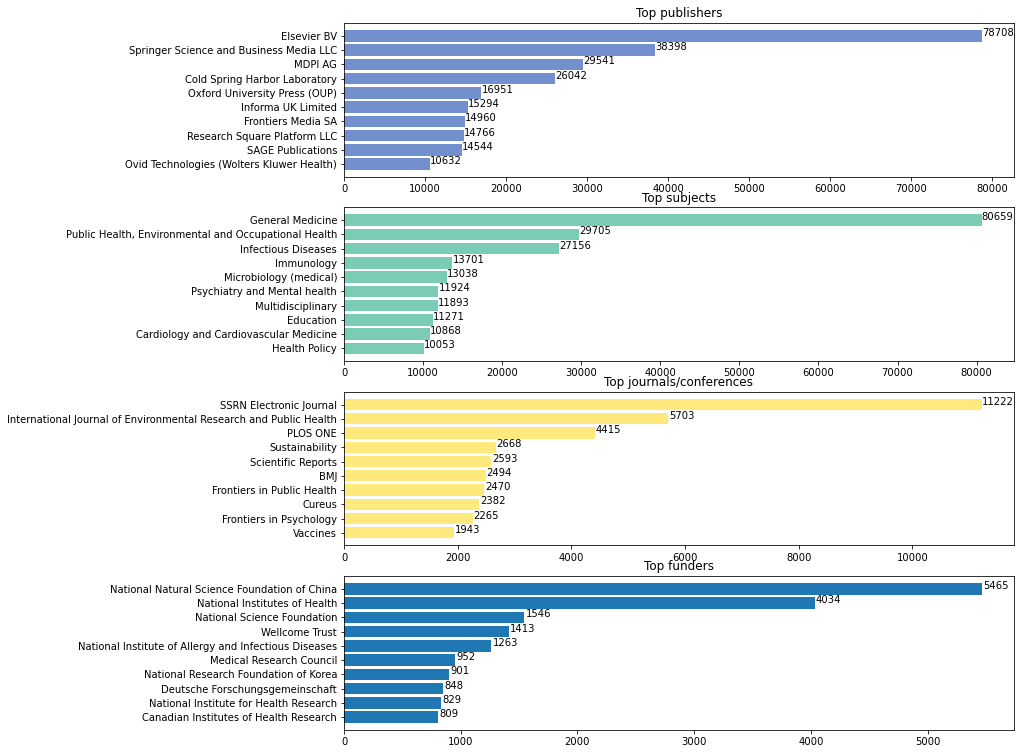

In [53]:
# Show metadata for entire articles
top_n = 10

print("Number of articles: {}".format(len(df)))
draw_subplots(top_n, count_publisher(df), count_subjects(df), count_container(df), count_funder(df))

### Metadata dependency matrix

In [54]:
top_n = 10

#### Publisher

In [56]:
metadata = 'publisher'

# get top n publishers
publishers_df = count_publisher(df)
top_publishers = publishers_df.publisher[:top_n]
top_publishers = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_publishers))

# create dependency matrix to save the percentage of articles with the publisher
publisher_df = pd.DataFrame()
publisher_df['publishers'] = top_publishers

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata].notnull()]
    for w in top_publishers:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    publisher_df['cluster#{}'.format(str(i))] = tmp_list

In [57]:
def draw_heatmap(df, metadata):
    
    fig = plt.figure(figsize=(15,8))
    plt.title(metadata, fontsize = 13) 
    conf_matrix_df = df.set_index(metadata)
    
    sns.heatmap(conf_matrix_df, annot=True, cmap="crest")

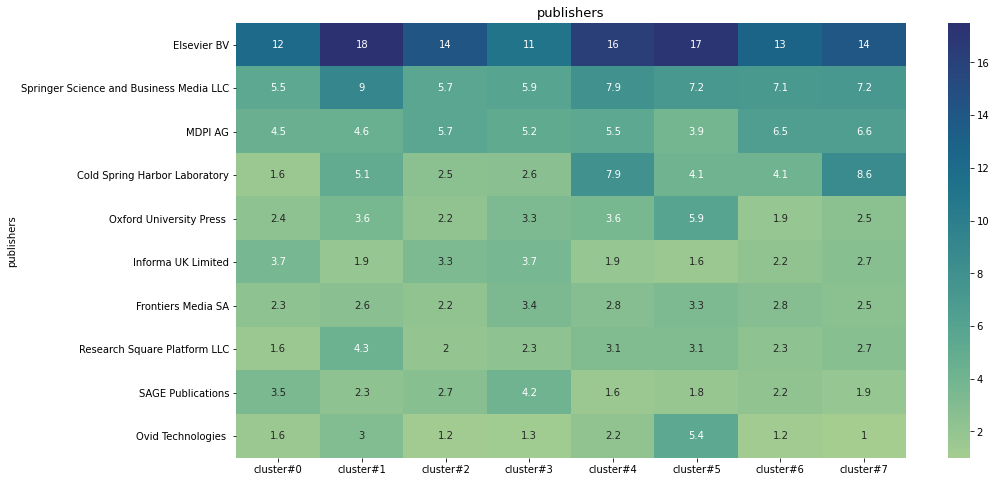

In [58]:
draw_heatmap(publisher_df, 'publishers')

#### Subject

In [59]:
metadata = 'Subject'

# get top n publishers
subject_df = count_subjects(df)
top_subjects = subject_df.Subjects[:top_n]
top_subjects = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_subjects))

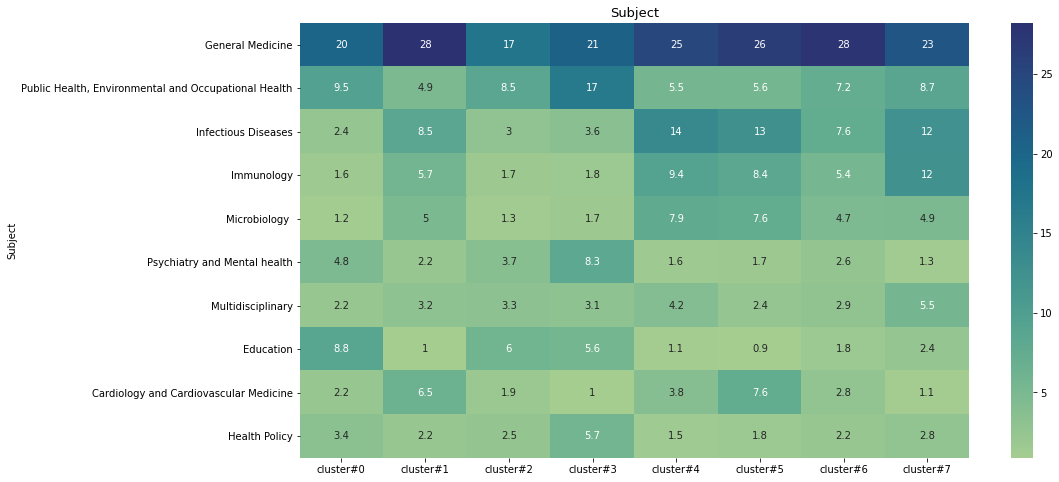

In [61]:
# create dependency matrix to save the percentage of articles with the publisher
subject_df = pd.DataFrame()
subject_df[metadata] = top_subjects

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df['subject'].notnull()]
    for w in top_subjects:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df['subject'].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    subject_df['cluster#{}'.format(str(i))] = tmp_list
draw_heatmap(subject_df, 'Subject')

#### Journal

In [62]:
metadata = 'container-title'

# get top n publishers
journal_df = count_container(df)
top_journals = journal_df['container_title'][:top_n]
top_journals = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_journals))

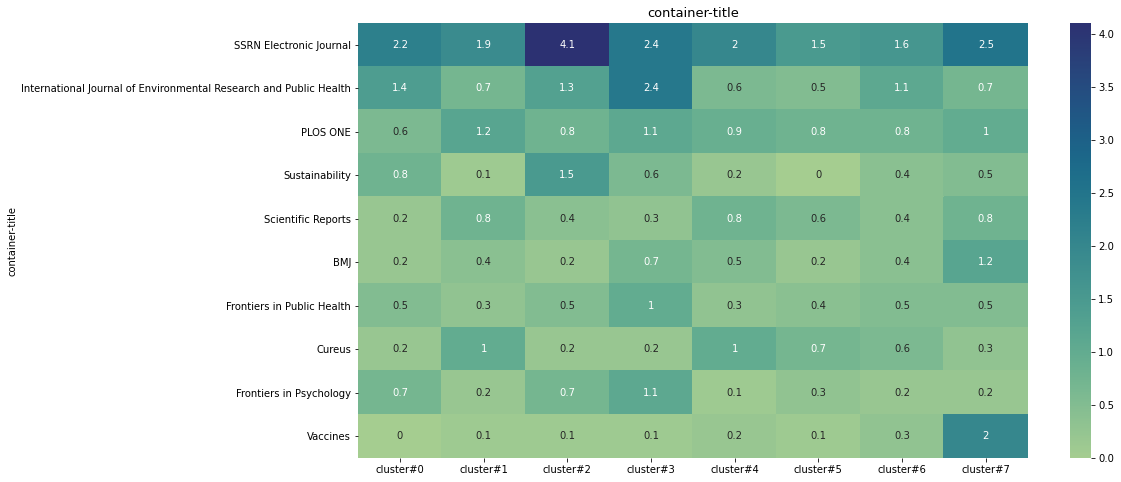

In [63]:
# create dependency matrix to save the percentage of articles with the journal
# code modified as string contain capture irrelevant journal

journal_df = pd.DataFrame()
journal_df[metadata] = top_journals

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata] != 'nan']
    for w in top_journals:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata] == "['{}']".format(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    journal_df['cluster#{}'.format(str(i))] = tmp_list
draw_heatmap(journal_df, 'container-title')

#### Funder

In [64]:
metadata = 'funder'

# get top n funder
funder_df = count_funder(df)
top_funder = funder_df['Funders'][:top_n]
top_funder = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_funder))

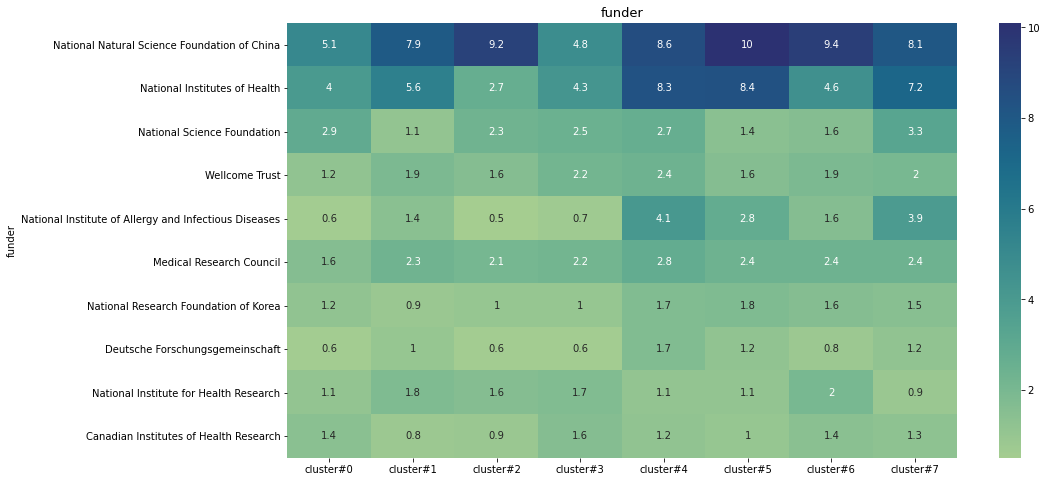

In [65]:
# create dependency matrix to save the percentage of articles with the funder

funder_df = pd.DataFrame()
funder_df[metadata] = top_funder

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata] != 'nan']
    for w in top_funder:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    funder_df['cluster#{}'.format(str(i))] = tmp_list
draw_heatmap(funder_df, 'funder')